#  Gene Sets and Expression for Tumor vs. Normal and Tissue Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design.

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as pyplot

# fix random seed for reproducibility
np.random.seed(42)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Expression and Convert To Hugo

Expression in TPM is only available with Ensembl gene identifiers from Xena. Load this up and convert into Hugo gene names.

In [13]:
%%time
expression = pd.read_hdf("data/TcgaTargetGtex_rsem_gene_tpm.hd5", "expression").sort_index(axis=1)
print("expression: samples={} genes={}".format(*expression.shape))

expression: samples=60498 genes=19260
CPU times: user 2.43 s, sys: 3.48 s, total: 5.91 s
Wall time: 5.89 s


In [4]:
"""
Feature labels are ensemble ids, convert to hugo gene names for use in interpreting
hidden layers in any trained models as they are better known to most bioinformaticians 
and clinicians. We're using an assembled table from John Vivian @ UCSC here. Another
option would be ftp://ftp.ebi.ac.uk/pub/databases/genenames/new/tsv/hgnc_complete_set.txt
"""
ensemble_to_hugo = pd.read_table(
    "https://github.com/jvivian/docker_tools/blob/master/gencode_hugo_mapping/attrs.tsv?raw=true",
    index_col=0)
ensemble_to_hugo.head()

,geneName,geneType,geneStatus,transcriptId,transcriptName,transcriptType,transcriptStatus,havanaGeneId,havanaTranscriptId,ccdsId,level,transcriptClass
geneId,,,,,,,,,,,,
ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,KNOWN,ENST00000456328.2,DDX11L1-002,processed_transcript,KNOWN,OTTHUMG00000000961.2,OTTHUMT00000362751.1,NaN,2,pseudo
ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,KNOWN,ENST00000450305.2,DDX11L1-001,transcribed_unprocessed_pseudogene,KNOWN,OTTHUMG00000000961.2,OTTHUMT00000002844.2,NaN,2,pseudo
ENSG00000227232.5,WASH7P,unprocessed_pseudogene,KNOWN,ENST00000488147.1,WASH7P-001,unprocessed_pseudogene,KNOWN,OTTHUMG00000000958.1,OTTHUMT00000002839.1,NaN,2,pseudo
ENSG00000278267.1,MIR6859-1,miRNA,KNOWN,ENST00000619216.1,MIR6859-1-201,miRNA,KNOWN,NaN,NaN,NaN,3,nonCoding
ENSG00000243485.3,RP11-34P13.3,lincRNA,KNOWN,ENST00000473358.1,RP11-34P13.3-001,lincRNA,KNOWN,OTTHUMG00000000959.2,OTTHUMT00000002840.1,NaN,2,nonCoding


In [14]:
hugo = ensemble_to_hugo[~ensemble_to_hugo.index.duplicated(keep='first')].reindex(expression.index.values)["geneName"].fillna("")
# Make sure we end up with the order of features being identical as some ensemble id's
# map to the same hugo gene id
assert(expression.index.equals(hugo.index))
# Change index from Ensembl to Hugo
expression_hugo = expression
expression_hugo.index = hugo.values

In [18]:
expression_hugo_mean = expression_hugo.groupby(expression.index).mean()

In [20]:
# Replace duplicate Hugo values with their mean and invert so matrix is in machine learning rows = samples
X = expression_hugo_mean.T
X.head()

,,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.9658,-9.9658,-9.9658,-9.965800,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.1140,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-7.911678,-9.9658
GTEX-1117F-0426-SM-5EGHI,-9.9658,-9.9658,-9.9658,-9.965800,1.1512,-1.2828,-6.5064,6.0777,-2.3147,0.5568,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-8.490334,-9.9658
GTEX-1117F-0526-SM-5EGHJ,-9.9658,-9.9658,-9.9658,-9.965800,5.2411,0.8488,-6.5064,10.0319,0.1257,-1.1172,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-8.653133,-9.9658
GTEX-1117F-0626-SM-5N9CS,-9.9658,-9.9658,-9.9658,-9.965800,5.4758,2.6325,-9.9658,9.7572,1.7702,-1.8836,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.231703,-9.9658
GTEX-1117F-0726-SM-5GIEN,-9.9658,-9.9658,-9.9658,-5.231167,4.5534,1.3051,-9.9658,7.7931,-0.0725,-2.2447,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.019897,-9.9658


## Ingest Expression and Gene Sets

Load the expression and clinical as wrangled in ingest.ipynb as well as gene sets downloaded from msigdb. Wrangle so that only genes present in each are present and ensure the order of features is consistent.

In [21]:
%%time
# Load samples and labels
# X = pd.read_hdf("data/TcgaTargetGtex_rsem_gene_tpm.hd5", "expression")
# print("X: samples={} genes={}".format(*X.shape))

Y = pd.read_table("data/TcgaTargetGTEX_phenotype.txt.gz", compression="gzip", header=0,
                      names=["id", "category", "disease", "primary_site", "sample_type", "gender", "study"],
                      sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str")
print("Y: samples={} labels={}".format(*Y.shape))

Y: samples=19131 labels=6
CPU times: user 71.3 ms, sys: 9.3 ms, total: 80.6 ms
Wall time: 78.7 ms


In [22]:
# Sort so indexes match
X.sort_index(axis=0, inplace=True)
X.sort_index(axis=1, inplace=True)
Y.sort_index(axis=0, inplace=True)

# Remove rows where the class is null or the sample is missing
intersection = X.index.intersection(Y[pd.notnull(Y["primary_site"])].index)
X = X[X.index.isin(intersection)]
Y = Y[Y.index.isin(intersection)]

# Make sure the label and example samples are in the same order
assert(X.index.equals(Y.index))

print(intersection.shape[0], "samples with non-null labels")

19126 samples with non-null labels


In [23]:
# Compute and add a tumor/normal column - TCGA and TARGET have some normal samples, GTEX is all normal.
Y.loc[:, "tumor_normal"] = Y.apply(
    lambda row: "Normal" if row["sample_type"] in ["Cell Line", "Normal Tissue", "Solid Tissue Normal"]
    else "Tumor", axis=1)

# Convert tumor_normal and primary_site into numerical values for two-hot multi-class training
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(encoder.fit_transform(Y["tumor_normal"]), index=Y.index)
encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(encoder.fit_transform(Y["primary_site"]), index=Y.index)
Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
count,19126,19126,19126,19126,18968,19126,19126,19126.000000,19126.000000
unique,93,93,46,16,2,3,2,NaN,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN,NaN
freq,1212,1212,1846,9185,10453,10534,10530,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550559,20.651992
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497450,12.419634
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,19.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000


In [24]:
X[0:20000:3000].head()

,,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,-9.9658,-9.9658,-9.9658,-9.965800,4.4595,0.9343,-5.0116,7.5126,0.8164,-2.1140,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-7.911678,-9.9658
GTEX-145LS-1226-SM-5Q5D9,-9.9658,-9.9658,-9.9658,-8.601650,3.3350,1.6281,-6.5064,11.3547,1.0847,-4.6082,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-8.314128,-9.9658
GTEX-X638-0126-SM-47JZ8,-9.9658,-9.9658,-9.9658,-9.965800,4.2609,1.6875,-4.0350,6.7694,0.7146,5.0845,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.334375,-9.9658
TCGA-24-1422-01,-9.9658,-9.9658,-9.9658,-8.618767,4.1962,2.3788,-5.5735,6.4925,0.6425,-0.6643,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-8.940686,-4.0350
TCGA-BF-AAP0-06,-9.9658,-9.9658,-9.9658,-9.965800,6.6121,3.7919,-9.9658,7.9917,0.1648,-4.6082,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.397798,-9.9658


In [25]:
Y[0:20000:3000].head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
id,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal,0,0
GTEX-145LS-1226-SM-5Q5D9,Lung,Lung,Lung,Normal Tissue,Female,GTEX,Normal,0,22
GTEX-X638-0126-SM-47JZ8,Skin - Sun Exposed (Lower Leg),Skin - Sun Exposed (Lower Leg),Skin,Normal Tissue,Female,GTEX,Normal,0,33
TCGA-24-1422-01,Ovarian Serous Cystadenocarcinoma,Ovarian Serous Cystadenocarcinoma,Ovary,Primary Tumor,Female,TCGA,Tumor,1,26
TCGA-BF-AAP0-06,Skin Cutaneous Melanoma,Skin Cutaneous Melanoma,Skin,Metastatic,Female,TCGA,Tumor,1,33


In [26]:
# Load gene sets from downloaded MSigDB gmt file (KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = { line.strip().split("\t")[0]: line.strip().split("\t")[2:] for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop any genes that are not in X - sort so that the order is the same as X_pruned.columns
gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values]) 
             for name, genes in gene_sets.items()}

# Find the union of all gene's in the gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19126, 5172)


In [27]:
# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

## Wrangle Labels, Train and Test Sets

Add one hot labels for tumor/normal and primary site and then build training and test sets stratifying on primary site.

In [28]:
# Create a multi-label output with tumor/normal + primary site one-hots
from keras.utils import np_utils
primary_site_one_hot = np_utils.to_categorical(Y["primary_site_value"])
tumor_normal_one_hot = Y["tumor_normal_value"]
Y_multiclass_onehot = np.append(
    tumor_normal_one_hot.values.reshape(tumor_normal_one_hot.shape[0],-1), 
    primary_site_one_hot, axis=1)
print(Y_multiclass_onehot.shape)
print(Y_multiclass_onehot[0:20000:5000])

(19126, 47)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [29]:
# Split into stratified training and test sets based on classes (i.e. tissue type) so that we have equal
# proportions of each tissue type in the train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["tumor_normal_value"]):
    X_train, X_test = X_pruned.values[train_index], X_pruned.values[test_index]
    y_train, y_test = Y_multiclass_onehot[train_index], Y_multiclass_onehot[test_index]
    classes_train, classes_test = Y["primary_site_value"].values[train_index], Y["primary_site_value"].values[test_index]

print(X_train.shape, X_test.shape)

(15300, 5172) (3826, 5172)


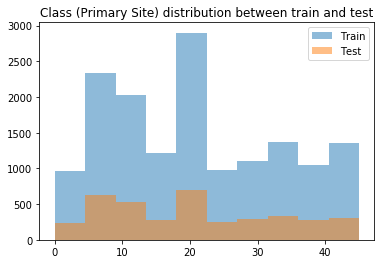

In [30]:
pyplot.hist(classes_train, alpha=0.5, label='Train')
pyplot.hist(classes_test, alpha=0.5, label='Test')
pyplot.legend(loc='upper right')
pyplot.title("Class (Primary Site) distribution between train and test")
pyplot.show()

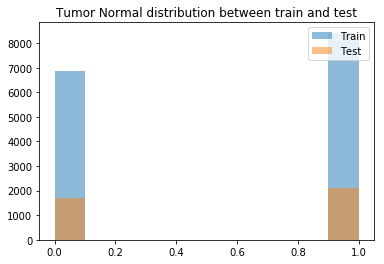

In [31]:
pyplot.hist(y_train[:, 0], alpha=0.5, label='Train')
pyplot.hist(y_test[:, 0], alpha=0.5, label='Test')
pyplot.legend(loc='upper right')
pyplot.title("Tumor Normal distribution between train and test")
pyplot.show()

## Tumor Normal Binary Classification
First train a basic binary tumor vs. normal classifier.

In [32]:
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

epochs=10
batch_size=128

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(8, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train[:,0], epochs=epochs, batch_size=batch_size, shuffle="batch", callbacks=callbacks)

print(model.metrics_names, model.evaluate(X_test, y_test[:,0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5172)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5172)              20688     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                165536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total para

## Multi-label Tumor vs. Normal and Primary Site Classification
Multi-label classification of tumor/normal + primary site with union of genes from all gene sets as input

In [33]:
%%time
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

epochs=10
batch_size=128

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(16, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),
    
    Dense(y_train.shape[1], activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", callbacks=callbacks)

print(model.metrics_names, model.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5172)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5172)              20688     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                165536    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 47)                799       
Total para

In [34]:
# Convert list of gene names into list of indexes into the features of X_pruned
gene_set_indexes = {name: np.searchsorted(X_pruned.columns.values, genes) for name, genes in gene_sets.items()}
print("Pathway KEGG_ABC_TRANSPORTERS Gene Indexes:", gene_set_indexes["KEGG_ABC_TRANSPORTERS"])

Pathway KEGG_ABC_TRANSPORTERS Gene Indexes: [  11   12   13   14   15   16   17   18   19   20   21   22   23   24
   25   26   27   28   29   30   31   32   33   34   35   36   37   38
   39   40   41   42   43   44   45   46   47   48   49   50   51  848
 4692 4693]


## Mulit-label Classification w/Per Pathway Sub-Network Input Layer
For each pathway build a custom input layer that extracts the expression levels for the genes in the pathway from the full input vector and feeds this into a dense single output hidden neuron. These are then aggregated and fed into a standard set of stacked layers and trained to classify tumor/norml and primary site. The hidden per pathway neurons are named after the pathway an 'may' indicate which pathway lead to a given classification.

In [35]:
%%time
from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.merge import concatenate
from keras import backend as K
import itertools

main_input = Input(shape=(X_train.shape[1],), name="main_input")

"""
Build per pathway sub-networks
"""
# Set to a small number (~4) for debugging, set to None to build all pathways
# max_num_pathways = 4
max_num_pathways = None 

# Extract the features/gene's for each pathway from the aggregate x input vector
pathways = [Lambda(lambda x: K.concatenate([x[:, i:i+1] for i in indexes]))(main_input)
            for name, indexes in itertools.islice(gene_set_indexes.items(), max_num_pathways)]

# Add a dense hidden layer per pathway with width proportional to the number of genes in the pathway
# pathways = [Dense(max(2, len(i)//4), activation='relu')(p) for p, i in zip(pathways, gene_set_indexes.values())]

# Add a named binary output for each pathway 
# pathways = [Dense(1, activity_regularizer=regularizers.l1(1e-5), activation='relu', name=name)(p) 
#             for p, name in zip(pathways, gene_set_indexes.keys())]

pathways = [Dropout(0.5)(Dense(1, activity_regularizer=regularizers.l1(1e-5), activation='relu', name=name)(p))
            for p, name in zip(pathways, gene_set_indexes.keys())]

# Concatenate the binary outputs of each of the sub-networks back into a single vector
x = keras.layers.concatenate(pathways)
           
"""
Add traditional stacked network for final multi-label classification
"""
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
    
x = Dense(8, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(inputs=[main_input], outputs=[x])
# print(model.summary())  # Too detailed when building full set of pathways
print("Trainable params::", np.sum([np.product(v.shape) for v in model.trainable_weights]).value)

Trainable params:: 16352
CPU times: user 1min 34s, sys: 2.02 s, total: 1min 36s
Wall time: 1min 36s


In [36]:
%%time
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="data/logs/{}".format(time()))

epochs=10
batch_size=128

print("Compiling and training...")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", 
          callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max"), tensorboard])
print(model.metrics_names, model.evaluate(X_test, y_test))

Compiling and training...
Epoch 1/10
15300/15300 [==============================] - 37s 2ms/step - loss: 1.0227 - acc: 0.7457
Epoch 2/10
15300/15300 [==============================] - 17s 1ms/step - loss: 0.5918 - acc: 0.8288
Epoch 3/10
15300/15300 [==============================] - 18s 1ms/step - loss: 0.3769 - acc: 0.9020
Epoch 4/10
15300/15300 [==============================] - 17s 1ms/step - loss: 0.2516 - acc: 0.9507
Epoch 5/10
15300/15300 [==============================] - 17s 1ms/step - loss: 0.2049 - acc: 0.9630
Epoch 6/10
15300/15300 [==============================] - 16s 1ms/step - loss: 0.1791 - acc: 0.9673
Epoch 7/10
15300/15300 [==============================] - 16s 1ms/step - loss: 0.1656 - acc: 0.9685
Epoch 00007: early stopping
3826/3826 [==============================] - 32s 8ms/step
['loss', 'acc'] [0.11067773076918383, 0.9691584472000693]
CPU times: user 8min 22s, sys: 2min 42s, total: 11min 4s
Wall time: 4min 8s


## Treehouse
Evaluate the model on samples from Treehouse

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")
    
if not os.path.exists("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.tsv.gz"):
    print("Downloading TCGA, TARGET and GTEX expression data from UCSC Xena")
    r = requests.get("https://treehouse.xenahubs.net/download/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.tsv.gz")
    r.raise_for_status()
    with open("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.tsv.gz", "wb") as f:
        for chunk in r.iter_content(32768):
            f.write(chunk)

if not os.path.exists("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.hd5"):
    print("Converting expression to dataframe and storing in hdf5 file")
    expression = pd.read_csv("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.tsv.gz", 
                             sep="\t", index_col=0).dropna().astype(np.float32)
    expression.to_hdf("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.hd5", "expression", mode="w", format="fixed")

treehouse_expression = pd.read_hdf("data/treehouse_public_samples_unique_hugo_log2_tpm_plus_1.2017-09-11.hd5", "expression").sort_index(axis=1)
print("expression: samples={} genes={}".format(*expression.shape))

Converting expression to dataframe and storing in hdf5 file


In [37]:
sample_id = "TH01_0717_S01"

x = pd.read_csv("/treehouse/archive/downstream/{}/secondary/ucsc_cgl-rnaseq-cgl-pipeline-3.3.4-785eee9/RSEM/Hugo/rsem_genes.hugo.results"
            .format(sample_id), 
            sep="\t").set_index("gene_name")
print(x.shape)
x.head()

(60448, 6)


,transcript_id(s),length,effective_length,expected_count,TPM,FPKM
gene_name,,,,,,
TSPAN6,"ENST00000373020.8,ENST00000494424.1,ENST000004...",2131.20,1986.93,155.00,1.95,5.18
TNMD,"ENST00000373031.4,ENST00000485971.1",1339.00,1194.73,2.00,0.04,0.11
DPM1,"ENST00000371582.8,ENST00000371584.8,ENST000003...",963.92,819.66,137.00,4.17,11.11
SCYL3,"ENST00000367770.5,ENST00000367771.10,ENST00000...",3037.97,2893.71,128.01,1.10,2.94
C1orf112,"ENST00000286031.10,ENST00000359326.8,ENST00000...",1863.66,1719.39,57.99,0.84,2.24


In [38]:
x_pruned = x.loc[X_pruned.columns.values]
x_pruned.sort_index(axis=0, inplace=True)
x_pruned = x_pruned[~x_pruned.index.duplicated(keep='first')]
x_pruned.shape

(5172, 6)

In [39]:
x_pruned["expected_count"].values

array([11809.04,   273.  ,   341.  , ...,   638.  ,    93.82,  1649.  ])

In [40]:
model.predict(np.array([x_pruned["FPKM"].values]))

array([[9.11246002e-01, 6.86533594e-19, 9.50189524e-23, 1.35506175e-25,
        2.45716101e-21, 1.34075418e-22, 5.62957246e-18, 3.02469971e-22,
        1.50773833e-29, 8.96338351e-11, 1.67384986e-13, 5.20123035e-30,
        2.80644934e-25, 6.93729254e-13, 3.63123822e-30, 1.07628665e-15,
        1.27661023e-32, 1.96785058e-28, 1.22029674e-20, 1.17232586e-21,
        3.36096236e-14, 1.02125776e-21, 5.51603671e-17, 1.46389221e-13,
        3.71290126e-37, 1.24981215e-20, 1.04258508e-28, 5.97230865e-20,
        1.97737215e-18, 2.46605748e-33, 1.51068103e-28, 1.53874162e-16,
        2.96808765e-29, 7.13299103e-20, 2.08419726e-09, 1.67728000e-23,
        7.94406518e-24, 2.03599489e-20, 7.95892175e-18, 1.86481548e-21,
        5.88688338e-25, 6.56929896e-32, 8.55488294e-25, 3.74134453e-18,
        1.34325850e-28, 5.08881470e-37, 1.84078295e-12]], dtype=float32)

In [41]:
!head /treehouse/archive/downstream/TH01_0717_S01/secondary/ucsc_cgl-rnaseq-cgl-pipeline-3.3.4-785eee9/RSEM/Hugo/rsem_genes.hugo.results

gene_name	transcript_id(s)	length	effective_length	expected_count	TPM	FPKM
TSPAN6	ENST00000373020.8,ENST00000494424.1,ENST00000496771.5,ENST00000612152.4,ENST00000614008.4	2131.2	1986.93	155.0	1.95	5.18
TNMD	ENST00000373031.4,ENST00000485971.1	1339.0	1194.73	2.0	0.04	0.11
DPM1	ENST00000371582.8,ENST00000371584.8,ENST00000371588.9,ENST00000413082.1,ENST00000466152.5,ENST00000494752.1	963.92	819.66	137.0	4.17	11.11
SCYL3	ENST00000367770.5,ENST00000367771.10,ENST00000367772.8,ENST00000423670.1,ENST00000470238.1	3037.97	2893.71	128.01	1.1	2.94
C1orf112	ENST00000286031.10,ENST00000359326.8,ENST00000413811.3,ENST00000459772.5,ENST00000466580.6,ENST00000472795.5,ENST00000481744.5,ENST00000496973.5,ENST00000498289.5	1863.66	1719.39	57.99	0.84	2.24
FGR	ENST00000374003.7,ENST00000374004.5,ENST00000374005.7,ENST00000399173.5,ENST00000457296.5,ENST00000468038.1,ENST00000475472.5	1825.22	1680.95	60.0	0.89	2.37
CFH	ENST00000359637.2,ENST00000367429.8,ENST00000466229.5,ENST00000470918.1,ENST000004967